# DCGAN

DCGAN，即deep convolutional GAN的簡寫

## 數據集

CIFAR10為32x32x3的照片，並擁有10個輸出類別，每個類別5,000張，共計50,000張照片

## 範例說明

為了簡化範例，單純的使用一個類別做測試

這邊會著重在實作，不會有過深的理論說明

## 作業開始

GAN由Generator與Discriminator兩個`nn`結合而成，迭代過程大致如下說明：  
1. 初始化Generator-v1與Discriminator-v1
2. 空間中sample出一筆資料，經過Generator-v1生成
3. Discriminator-v1驗證真假，發現是假
4. Generator-v1升級為Generator-v2
5. 成功騙過Discriminator
6. Discriminator-v1升級為Discriminator-v2
7. Discriminator-v2驗證真假，發現是假
8. ....

作業開始之前定義使用的GPU資源

In [1]:
import os
# 限制gpu資源
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

首先我們建置Generator

載入建置Generator的需求套件

In [3]:
import keras
from keras import layers
import numpy as np

這是後面保有照片會用到的套件

In [41]:
from keras.preprocessing import image

定義dimension，CIFAR10的照片維度為32x32x3

Generator會從空間中sample出一個點，那個點是一個Vector，在下面範例中即是laten_dim的設置

In [9]:
# CIFAR10資料維度
height = 32
width = 32
channel =3

# 預計生成資料維度
laten_dim = 32

* W：輸入維度
* F：filter size
* S：stride
* P：padding size
* N：輸入維度

`layers.Conv2D`：卷積，經過卷積之後的維度計算如下：  
$N=(W-F+2P)/S+1$

`layers.Conv2DTranspose`：反卷積，經過反卷積之後的維度計算如下：  
$W=(N-1)*S-2P+F$

In [7]:
generator_input = keras.Input(shape=(laten_dim, ))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 輸出為32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 圖片channel設置為3，即輸出為32x32x3
x = layers.Conv2D(channel, 7, activation='tanh', padding='same')(x)

generator = keras.models.Model(generator_input, x)

利用`Model.summary()`來確認模型的資料維度變化

In [8]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

Generator完成之後我們要架構Discriminator，Discriminator的作用就是判斷給定的資料是真或假，因此它的輸入維度即照片維度(範例為32x32x3)

In [10]:
discriminator_input = layers.Input(shape=(height, width, channel))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
# 判斷真假，因此輸出為1個unit，並搭配sigmoid
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


利用`Model.summary()`確認模型維度變化

In [11]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

定義模型最佳化方式

範例使用`RMSprop`做為最佳化的方式，透過`clipvalue`來限制梯度範圍

In [13]:
discriminator_optimizer = keras.optimizers.RMSprop(
    lr = 0.0008,
    clipvalue=1.0,
    decay=1e-8
)

In [14]:
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

Generator與Discriminator都已經設置好了，現在我們要讓他們對抗，幾個點簡單說明：  
1. 原始GAN中雖然提到Generator要訓練多次，但實際上Ian Goodfellow只訓練一次而以
2. 訓練Generator的時候Discriminator是凍結的

首先，將discriminator凍結

In [15]:
discriminator.trainable = False

gan model的input是一開始所設置的`laten_dim`，而output的部份則是`generator model`的output給`discriminator model`的input所做的判斷，即判斷`generator model`所生成的資料是真還是假

In [ ]:
gan_input = keras.Input(shape=(laten_dim, ))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

設置`gan model`的最佳化方式

In [19]:
gan_optimizer = keras.optimizers.RMSprop(
    lr=0.0004,
    clipvalue=1.0,
    decay=1e-8
)

In [20]:
gan.compile(optimizer=gan_optimizer,
            loss='binary_crossentropy')

In [21]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_3 (Model)              (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


現在我們可以開始來訓練模型，上面提到，我們會從空間隨機sample出資料，經過`generator model`來生成，這筆資料當然假資料，其標記為`Negative`，另外我們也會有真實的資料，其標記為`Positive`。

首先我們先下載keras自帶的資料集，`CIFAR10`：
* 0: airplane
* 1: automobile
* 2: bird
* 3: cat
* 4: deer
* 5: dog
* 6: frog
* 7: horse
* 8: ship
* 9: truck

In [23]:
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 109s 1us/step


任何資料集都請務必先行驗證確認資料維度

In [28]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

下載下來的照片資料，我們只會採用其中一個類別來簡化範例的進行

以`y_train.flatten() == 5`為mask來取得資料

In [30]:
x_train = x_train[y_train.flatten() == 5]

調整之後確認資料維度

In [31]:
x_train.shape

(5000, 32, 32, 3)

後面不需要太過在意`y_train`，因為對我們目前需求來說，所有真實資料皆為`Positive`

In [32]:
x_train.dtype

dtype('uint8')

資料標準化

In [34]:
x_train = x_train / 255.

In [35]:
x_train.dtype

dtype('float64')

轉換型別，理論上使用`float32`足矣

In [36]:
x_train = x_train.astype(np.float32)

In [37]:
x_train.dtype

dtype('float32')

設置幾個簡單參數

In [107]:
# 預計執行迭代次數
iterations = 50000
# 每次處理數量
batch_size = 20
# 預計保存生成照片資料集，依個人需求設置
folder_path = '/tf/GAN/DCGAN' 

前置作業完畢之後就可以正式的來訓練模型

In [108]:
# 記錄起始索引的參數
idx_start = 0
for i in range(iterations):
    # 從高斯分佈空間中隨機sample出資料點
    random_vectors = np.random.normal(size=(batch_size, laten_dim))
    # 從generator model取得output
    # 依我們所設置的模型，會回傳Nx32x32x3的資料
    generator_img = generator.predict(random_vectors)
    # 目前的結束索引
    idx_stop = idx_start + batch_size
    # 利用索引取得相對應的真實照片
    true_imgs = x_train[idx_start: idx_stop]
    # 將真假堆疊在一起
    combian_imgs = np.concatenate([generator_img, true_imgs])
    # 產生相對應的label，生成為假：1，真實照片：0
    labels = np.concatenate([np.ones((batch_size, 1)), 
                             np.zeros((batch_size, 1))])
    
    # 在label中加入隨機的噪點，很多事不能說明為什麼
    # 跟著打牌就不會放槍就是了
    labels += 0.05 * np.random.random(labels.shape)
    
    # 目前已經隨機生成照片，要拿這些照片來訓練discriminator
    discriminator_loss = discriminator.train_on_batch(combian_imgs, labels)
    
    # 現在，discriminator已經知道這些是假照片，因此要更新generator
    # 接下來的生成照片，印象中李弘毅老師的線上課程中有提到，要不要重新生成都可以    
    random_vectors = np.random.normal(size=(batch_size, laten_dim))
    # 產生上面新生成照片的labels
    # 這邊設置的標籤是『Positive』，這是因為我們要欺騙discriminator
    # 讓discriminator感覺這個generator生成的照片是真的
    # 這個過程之後generator就升級了
    generator_labels = np.zeros((batch_size, 1))
    # 訓練gan model，記得這時候訓練的是我們凍結discriminator的模型-gan
    gan_loss = gan.train_on_batch(random_vectors, generator_labels)
    
    # 更新索引
    idx_start = idx_start + batch_size 
    # 判斷索引是否超過資料集索引，超過的話就重新計算
    # 這邊也要特別注意到資料集數量與batch_size的設置關係，要可以整除
    if idx_start > len(x_train) - batch_size:
        idx_start = 0
        
    # 這邊每100次迭代記錄一次
    if i % 100 == 0:
        gan.save_weights('gan.h5')
        
        print('discriminator loss: ', discriminator_loss)
        print('gan loss: ', gan_loss)
        
        save_generator_img(generator_img, 4, 5, i)
#         img = image.array_to_img(generator_img[0] * 255., scale=False)
#         img.save(os.path.join(folder_path, 'epoch-' + str(i) + '-generator.jpg'))
        
#         img = image.array_to_img(true_imgs[0] * 255., scale=False)
#         img.save(os.path.join(folder_path, 'epoch-' + str(i) + '-true_image.jpg'))        
    

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss:  0.71282643
gan loss:  0.87302893
discriminator loss:  0.66943425
gan loss:  0.7812395
discriminator loss:  0.697122
gan loss:  0.8018481
discriminator loss:  0.6686786
gan loss:  0.7651623
discriminator loss:  0.7016796
gan loss:  0.7988683
discriminator loss:  0.6718914
gan loss:  0.75036573
discriminator loss:  0.6425274
gan loss:  0.88958186
discriminator loss:  0.6744896
gan loss:  0.77555877
discriminator loss:  0.7213212
gan loss:  0.821689
discriminator loss:  0.7596559
gan loss:  0.56101835
discriminator loss:  0.68560475
gan loss:  0.71743935
discriminator loss:  0.6524574
gan loss:  0.77833223
discriminator loss:  0.6425224
gan loss:  0.98320067
discriminator loss:  0.6600302
gan loss:  0.7566779
discriminator loss:  0.7357922
gan loss:  0.74119204
discriminator loss:  0.704436
gan loss:  0.9978873
discriminator loss:  0.57642615
gan loss:  0.66470855
discriminator loss:  0.6887396
gan loss:  0.7631684
discriminator loss:  0.71840274
gan loss:  1.2065418


discriminator loss:  0.45834723
gan loss:  2.1585457
discriminator loss:  -0.0016404182
gan loss:  12.681487
discriminator loss:  -0.11279134
gan loss:  14.133786
discriminator loss:  -0.09021057
gan loss:  15.625987
discriminator loss:  -0.08346568
gan loss:  15.942385
discriminator loss:  -0.19760992
gan loss:  15.942385
discriminator loss:  -0.13909705
gan loss:  15.942385
discriminator loss:  -0.1126558
gan loss:  15.942385
discriminator loss:  -0.19497378
gan loss:  15.942385
discriminator loss:  -0.1329669
gan loss:  15.942385
discriminator loss:  -0.15841036
gan loss:  15.942385
discriminator loss:  -0.0883198
gan loss:  15.942385
discriminator loss:  -0.15021986
gan loss:  15.942385
discriminator loss:  -0.13882737
gan loss:  15.942385
discriminator loss:  -0.12894946
gan loss:  15.942385
discriminator loss:  -0.14658801
gan loss:  15.942385
discriminator loss:  -0.109984934
gan loss:  15.942385
discriminator loss:  -0.13582467
gan loss:  15.942385
discriminator loss:  -0.14946

discriminator loss:  -0.123353615
gan loss:  15.942385
discriminator loss:  -0.17884359
gan loss:  15.942385
discriminator loss:  -0.13867031
gan loss:  15.942385
discriminator loss:  -0.15428571
gan loss:  15.942385
discriminator loss:  -0.1610001
gan loss:  15.942385
discriminator loss:  -0.08125786
gan loss:  15.942385
discriminator loss:  -0.13780746
gan loss:  15.942385
discriminator loss:  -0.13964298
gan loss:  15.942385
discriminator loss:  -0.14595878
gan loss:  15.942385
discriminator loss:  -0.12967394
gan loss:  15.942385
discriminator loss:  -0.17993483
gan loss:  15.942385
discriminator loss:  -0.14487562
gan loss:  15.942385
discriminator loss:  -0.13019896
gan loss:  15.942385
discriminator loss:  -0.11352603
gan loss:  15.942385
discriminator loss:  -0.110939525
gan loss:  15.942385
discriminator loss:  -0.14877193
gan loss:  15.942385
discriminator loss:  -0.13520889
gan loss:  15.942385
discriminator loss:  -0.118448414
gan loss:  15.942385
discriminator loss:  -0.18

discriminator loss:  -0.12936291
gan loss:  15.942385
discriminator loss:  -0.15830667
gan loss:  15.942385
discriminator loss:  -0.12100054
gan loss:  15.942385
discriminator loss:  -0.09006938
gan loss:  15.942385
discriminator loss:  -0.1167144
gan loss:  15.942385
discriminator loss:  -0.11599078
gan loss:  15.942385
discriminator loss:  -0.13704467
gan loss:  15.942385
discriminator loss:  -0.16465047
gan loss:  15.942385
discriminator loss:  -0.19673151
gan loss:  15.942385
discriminator loss:  -0.123262405
gan loss:  15.942385
discriminator loss:  -0.13498439
gan loss:  15.942385
discriminator loss:  -0.15211482
gan loss:  15.942385
discriminator loss:  -0.11275093
gan loss:  15.942385
discriminator loss:  -0.12630716
gan loss:  15.942385
discriminator loss:  -0.09205715
gan loss:  15.942385
discriminator loss:  -0.13993624
gan loss:  15.942385
discriminator loss:  -0.1275923
gan loss:  15.942385
discriminator loss:  -0.118582584
gan loss:  15.942385
discriminator loss:  -0.1742

## 確認生成照片

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

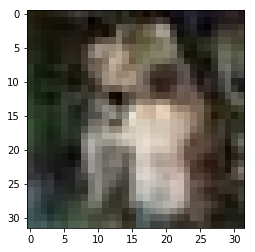

In [70]:
img_path = 'epoch-9600-generator.jpg'
gen_img = mpimg.imread(img_path)
plt.imshow(gen_img)

像哈巴狗?

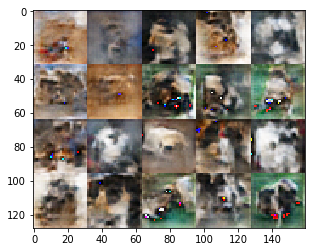

In [106]:
img_path = 'generator9800.png'
gen_img = mpimg.imread(img_path)
plt.imshow(gen_img)

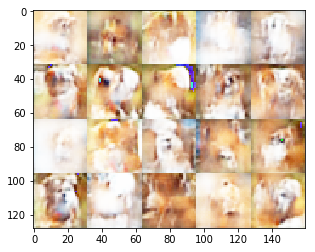

In [117]:
img_path = 'generator14800.png'
gen_img = mpimg.imread(img_path)
plt.imshow(gen_img)

## 結論

範例可以看的出來，在Keras的高階api協助之下，實作GAN並不是那麼樣子的困難，但GAN的訓練有許多比程式碼還要困難的部份(上面結果可以發現，優化的並不是那麼好)，不管是Generator還是Discriminator，過強或過弱對模型來說都不是好事，許多情況下GAN難以訓練，需要的是參數上的不斷調校，唯有不斷的踩雷才能擁有足夠的經驗。

後記：後面繼續訓練約50,000次迭代之後就整個壞掉了!

## 延伸

單純保存一張照片似乎較難以判斷生成狀況，下面function將圖片串接起來

直接使用keras自帶工具來處理照片保存的作業

In [72]:
import numpy as np
from keras.preprocessing import image

In [101]:
def save_generator_img(generator_img, h_int, w_int, epoch, save_file_name='generator', save_dir='.'):
    """保存generator生成的照片
    function:
        利用keras自帶工具keras.preprocessing.Image保存照片
    
    parameters:
        generator_img: generator生成的numpy object
        h_int: 湊成一張照片的時候高要幾張
        w_ing: 湊成一張照片的時候寬要幾張
        epoch: 第幾次的迭代，保存照片的時候插入檔案名稱
        save_file_name: 檔案名稱，預設為generator
        save_dir: 保存的路徑，預設在執行程式的根目錄    
        
    remark:
        h_int x w_int 不能超過generator_img的長度，一定只能等於
    
    example:
        save_generator_img(generator_img, 4, 5, 9900)
    """
    # 取得資料維度
    N, H, W, C = generator_img.shape
    
    # 驗證拼湊照片數量相符
    assert int(h_int) * int(w_int) == N        
    
    # 開一張全zero的大陣列
    target_img = np.zeros(shape=(h_int * H, w_int * W, C))
    
    # 索引
    now_idx = 0    
    for h_idx in range(h_int):
        for w_idx in range(w_int):
            # 取得照片
            _img = generator_img[now_idx]
            # 取代相對應陣列位置
            target_img[h_idx * H: h_idx * H + H, w_idx * W: w_idx * W + W] = _img                        
            now_idx += 1
    
    
    file_name = os.path.join(save_dir, save_file_name + str(epoch) + '.png')
    save_img = image.array_to_img(target_img * 255., scale=False)
    save_img.save(file_name)                         